In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

## Data Modeling Workflow

## Load Data

In [ ]:
# read csv file
data = pd.read_csv('../data/merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

## Review Tests

In [ ]:
test_names = [
 #'Propoxyphene',
 #'Amphetamines',
 'Cannabinoids',
 #'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# call helper function to build  the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)

## Review Surveys


In [ ]:
# comment out the drugs you don't want to include
survey_names = [
'cannabis',
'cocaine',
'alcohol',
#'oxycodone',
#'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

## Create Dataframe for Baseline Numeric Predictors

In [ ]:
# attendance data, included up to week 4
rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

# medication data, included up to week 4
meds = data[[col for col in data.columns if 'med' in col]].iloc[:, :10]

# cow data, included for baseline and week 0
cows = data[[col for col in data.columns if 'cows' in col]]

# create dataframe with numeric features
num_df = pd.concat([tests, surveys, rsa, meds, cows], axis=1)

print('Shape of numeric dataframe',num_df.shape)
display(num_df)

## Review Categorical

In [8]:
# demographic data
dem = data[[col for col in data.columns if col.startswith('dem_')]]
#dem = pd.get_dummies(dem, dtype=int)
# create df for diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]
#dsm = pd.get_dummies(dsm, dtype=int)
# create df for medical history
mdh = data[[col for col in data.columns if col.startswith('mdh_')]]
#mdh = pd.get_dummies(mdh, dtype=int)

# create df for physical exam
pex = data[[col for col in data.columns if col.startswith('pex_')]]
#pex = pd.get_dummies(pex, dtype=int)

# concat cat features into cat_df
cat_df = pd.concat([dsm, dem, mdh, pex], axis=1)

print('shape of the categorical df:',cat_df.shape)
display(cat_df)

shape of the categorical df: (1917, 39)


,dsm_cannabis,dsm_cocaine,dsm_sedative,dsm_opiates,dsm_alcohol,dsm_amphetamine,dem_gender,dem_ethnicity,dem_race,mdh_liver_problems,...,pex_respiratory,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin
0,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,male,not_spanish_origin,white,yes_history,...,normal,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal
1,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,male,not_spanish_origin,white,no_history,...,normal,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal
2,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,male,not_spanish_origin,white,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,abnormal
3,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,female,not_spanish_origin,white,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
4,not_present,not_present,not_present,not_present,not_present,not_present,male,not_spanish_origin,white,not_evaluated,...,not_present,not_present,not_present,not_present,not_present,not_present,not_present,not_present,not_present,not_present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,female,not_spanish_origin,white,yes_history,...,normal,normal,abnormal,normal,normal,normal,normal,normal,normal,abnormal
1913,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,male,not_spanish_origin,white,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,abnormal
1914,not_present,not_present,not_present,not_present,not_present,not_present,female,not_spanish_origin,white,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,abnormal,normal
1915,no_diagnosis,abuse,dependence,dependence,abuse,abuse,male,not_spanish_origin,white,yes_history,...,not_present,not_present,not_present,not_present,not_present,not_present,not_present,not_present,not_present,not_present


### We found some noisy data in this dataset
There were two different imputations applied to dsm columns<br>
Combine 'not_present' and 'not_evaluated' to 'not_evaluated'<br>
There is a 0 value in `dem_gender` in 3 rows, we will delete them<br>

In [9]:
# replace values labeled 'not_present', with 'not_evaluated'
cat_df = cat_df.replace('not_present', 'not_evaluated')

# remove rows with 0 values
cat_df.loc[cat_df.dem_gender!='0']

cat_df.shape

(1917, 39)

In [10]:
# one hot encode cat_df
cat_df = pd.get_dummies(cat_df, drop_first=True, dtype=float)

print(cat_df.shape)
display(cat_df)

(1917, 88)


,dsm_cannabis_dependence,dsm_cannabis_no_diagnosis,dsm_cannabis_not_evaluated,dsm_cocaine_dependence,dsm_cocaine_no_diagnosis,dsm_cocaine_not_evaluated,dsm_sedative_dependence,dsm_sedative_no_diagnosis,dsm_sedative_not_evaluated,dsm_opiates_dependence,...,pex_gen_appearance_normal,pex_gen_appearance_not_evaluated,pex_ears_nose_throat_normal,pex_ears_nose_throat_not_evaluated,pex_head_neck_normal,pex_head_neck_not_evaluated,pex_cardio_normal,pex_cardio_not_evaluated,pex_skin_normal,pex_skin_not_evaluated
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1913,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1914,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1915,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


## Assign Target Variable and Combine

In [11]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1917, 129)


,test_Cannabinoids_0,test_Cocaine_0,test_Opiate300_0,test_Cannabinoids_1,test_Cocaine_1,test_Opiate300_1,test_Cannabinoids_2,test_Cocaine_2,test_Opiate300_2,test_Cannabinoids_3,...,pex_gen_appearance_not_evaluated,pex_ears_nose_throat_normal,pex_ears_nose_throat_not_evaluated,pex_head_neck_normal,pex_head_neck_not_evaluated,pex_cardio_normal,pex_cardio_not_evaluated,pex_skin_normal,pex_skin_not_evaluated,dropout
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1913,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1914,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1915,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Save to CSV for ML Pipelines

In [ ]:
# save to csv
new_data.to_csv('../data/classification_df.csv', index=False)

## Classification Workflow

In [12]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np


# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(new_data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1341, 128)
Shape of X_val: (192, 128)
Shape of X_test: (384, 128)


In [13]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
	'subsample': [0.3, 0.5, 0.9],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=4, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.5}
Highest ROC AUC found:  0.8931815414024962


In [14]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

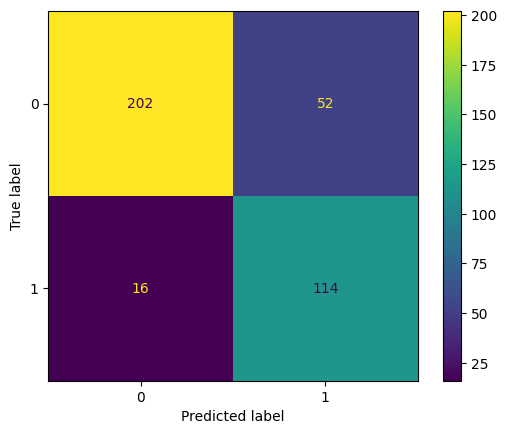

In [15]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

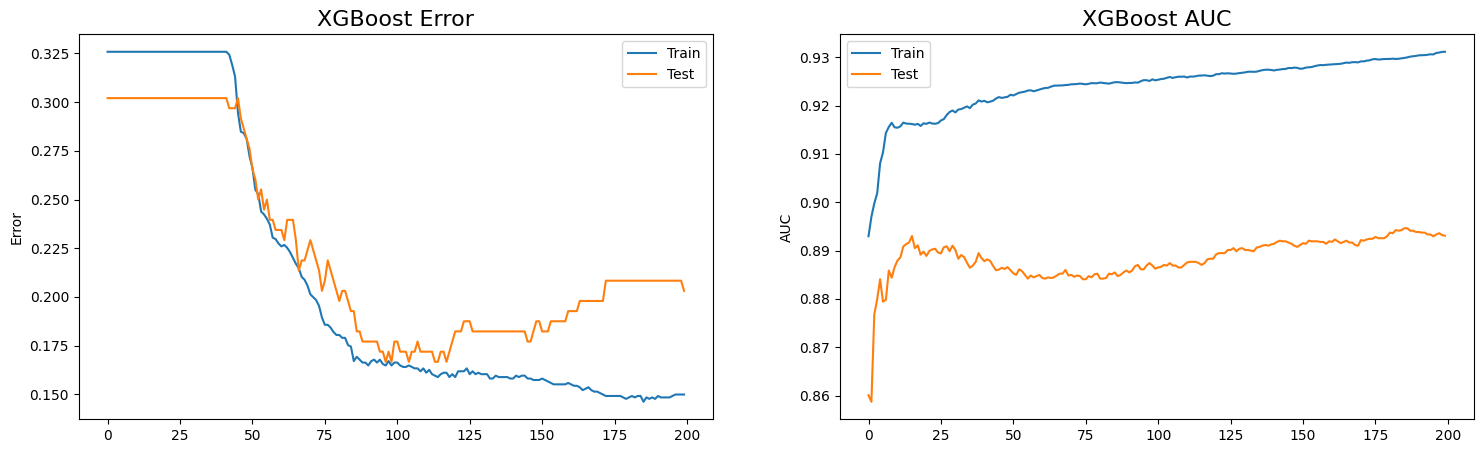

In [16]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [17]:
# Print the classification report
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

# print accuracy for train, val and test
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy: ", accuracy_score(y_val, y_pred_val))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))


Train Accuracy:  0.8501118568232662
Validation Accuracy:  0.796875
Test Accuracy:  0.8229166666666666


In [18]:
# print classification report for training
print('Train Classification Report')
print(classification_report(y_train, y_pred_train))

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       904
         1.0       0.72      0.89      0.79       437

    accuracy                           0.85      1341
   macro avg       0.83      0.86      0.84      1341
weighted avg       0.87      0.85      0.85      1341



In [19]:
# Print the classification report for test
print("Test classification report:")
print(classification_report(y_test, y_pred_test))

Test classification report:
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86       254
         1.0       0.69      0.88      0.77       130

    accuracy                           0.82       384
   macro avg       0.81      0.84      0.81       384
weighted avg       0.85      0.82      0.83       384



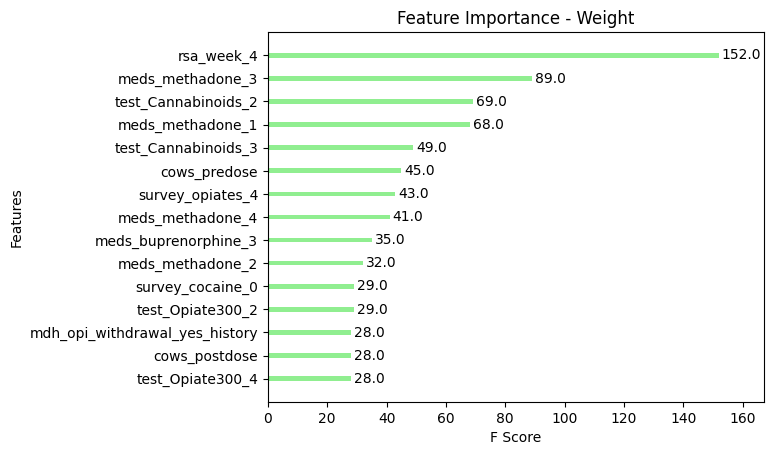

In [20]:
# plot feature importance
xgb.plot_importance(grid_auc.best_estimator_, importance_type='weight', max_num_features=15, title='Feature Importance - Weight', xlabel='F Score', ylabel='Features', color='lightgreen', grid=False)
plt.show()

In [21]:
# Assuming `model` is your trained model and `X_test`, `y_test` are your test datasets
predictions = best_gbm.predict(X_test)

# Convert X_test to a DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add predictions and actual labels to the DataFrame
X_test_df['Prediction'] = predictions
X_test_df['Actual'] = y_test

# Function to classify each prediction
def classify_prediction(row):
	if row['Prediction'] == row['Actual']:
		return 'TP' if row['Prediction'] == 1 else 'TN'
	else:
		return 'FP' if row['Prediction'] == 1 else 'FN'

# Apply the function to classify predictions
X_test_df['Classification'] = X_test_df.apply(classify_prediction, axis=1)

# Now X_test_df includes the test data, predictions, actual labels, and classification (TP, TN, FP, FN)
X_test_df

,test_Cannabinoids_0,test_Cocaine_0,test_Opiate300_0,test_Cannabinoids_1,test_Cocaine_1,test_Opiate300_1,test_Cannabinoids_2,test_Cocaine_2,test_Opiate300_2,test_Cannabinoids_3,...,pex_ears_nose_throat_not_evaluated,pex_head_neck_normal,pex_head_neck_not_evaluated,pex_cardio_normal,pex_cardio_not_evaluated,pex_skin_normal,pex_skin_not_evaluated,Prediction,Actual,Classification
816,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,TN
114,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.0,TN
702,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0,TN
1088,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.0,TN
1081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1.0,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.0,TN
366,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,FP
580,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.0,TN
721,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0,FN


## Create a DF with all the trees

In [22]:
# Assuming `grid_auc` is your trained GridSearchCV object with an XGBClassifier
best_model = grid_auc.best_estimator_

# Extract the Booster
booster = best_model.get_booster()

# Convert the trees to a DataFrame
trees_df = booster.trees_to_dataframe()

trees_df.loc[trees_df['Feature']=='rsa_week_4']

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,rsa_week_4,1.0,0-1,0-2,0-2,291.200104,143.839020,NaN
13,1,0,1-0,rsa_week_4,1.0,1-1,1-2,1-2,308.139709,148.924698,NaN
28,2,0,2-0,rsa_week_4,1.0,2-1,2-2,2-2,292.333771,147.167099,NaN
41,3,0,3-0,rsa_week_4,1.0,3-1,3-2,3-2,267.339691,149.521439,NaN
54,4,0,4-0,rsa_week_4,1.0,4-1,4-2,4-2,283.474823,146.574280,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2472,184,0,184-0,rsa_week_4,1.0,184-1,184-2,184-2,21.415091,100.443321,NaN
2550,190,0,190-0,rsa_week_4,1.0,190-1,190-2,190-2,20.996149,97.641579,NaN
2613,195,0,195-0,rsa_week_4,1.0,195-1,195-2,195-2,21.880119,105.008141,NaN
2626,196,0,196-0,rsa_week_4,1.0,196-1,196-2,196-2,22.160376,96.700905,NaN


## Plot the Estimator with the Desired Feature

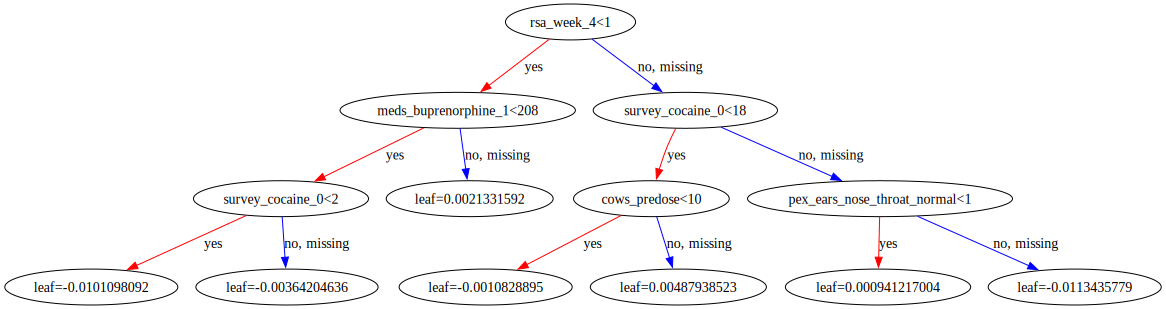

In [24]:
graph = xgb.to_graphviz(booster, num_trees=199)
graph

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load a dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual pipelines for each classifier
clf1 = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))
clf3 = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))

# Combine them in a VotingClassifier
eclf = VotingClassifier(estimators=[
		('lr', clf1), ('rf', clf2), ('gbc', clf3)],
		voting='hard')

# Fit the ensemble classifier
eclf.fit(X_train, y_train)

# Now you can use eclf to predict and evaluate
print(eclf.score(X_test, y_test))